<a href="https://colab.research.google.com/github/xseeker0/neural-scratchpad/blob/main/practice_2_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural net

## Layer

In [1]:
import torch
import torch.nn as nn
import math

class MyLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # He Initialization
        self.weight = nn.Parameter(torch.randn(in_features, out_features) * math.sqrt(2. / in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        # y = xW + b
        return torch.matmul(x, self.weight) + self.bias

class MyFlatten(nn.Module):
    def forward(self, x):
        # Keep batch size (dim 0) and flatten all other dimensions
        return x.view(x.size(0), -1)

class Sigmoid(nn.Module):
    def forward(self, x):
        # Sigmoid activation function: f(x) = 1 / (1 + e^(-x))
        # Maps input values to the range (0, 1)
        return 1 / (1 + torch.exp(-x))

class MyReLU(nn.Module):
    def forward(self, x):
        # f(x) = max(0, x)
        return torch.clamp(x, min=0)

## Optimizer
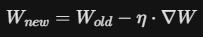

In [2]:
class MySGD:
    def __init__(self, params, lr):
        """
        Initialize the optimizer.
        params: Iterable of parameters to optimize (typically model.parameters())
        lr: Learning rate for the update rule
        """
        # Store parameters as a list to ensure they can be iterated multiple times
        self.params = list(params)
        self.lr = lr

    def step(self):
        """
        Performs a single optimization step (parameter update).
        """
        with torch.no_grad():
            for param in self.params:
                if param.grad is not None:
                    # Apply the SGD update rule: w = w - lr * grad
                    param.data -= self.lr * param.grad

    def zero_grad(self):
        """
        Resets the gradients of all optimized parameters to zero.
        """
        for param in self.params:
            if param.grad is not None:
                # Use in-place zeroing to clear the gradient buffer
                param.grad.zero_()

## Cost (Loss function)
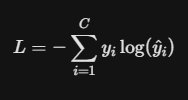

In [3]:
class MyCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, targets):
        """
        logits: (batch_size, num_classes) - Raw unnormalized scores from the model
        targets: (batch_size) - Ground truth class indices (not one-hot encoded)
        """
        # 1. Find max value for numerical stability (Log-Sum-Exp trick)
        max_logits = torch.max(logits, dim=1, keepdim=True)[0]

        # 2. Compute Log-Sum-Exp: log(sum(exp(x - max))) + max
        log_sum_exp = torch.log(torch.sum(torch.exp(logits - max_logits), dim=1, keepdim=True)) + max_logits

        # 3. Extract the logits of the correct classes
        # targets.view(-1, 1) allows selecting the correct index for each batch element
        correct_class_logits = torch.gather(logits, 1, targets.view(-1, 1))

        # 4. Cross Entropy Formula: Loss = - (logit_correct - log_sum_exp)
        loss = - (correct_class_logits - log_sum_exp)

        # Return the mean loss over the batch
        return loss.mean()

Model

### Prepare data

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.5MB/s]


### Model architect

In [5]:
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = MyFlatten()
        self.linear_relu_stack = nn.Sequential(
            MyLinear(28*28, 512),
            MyReLU(),
            MyLinear(512, 512),
            MyReLU(),
            MyLinear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = MyNeuralNetwork()

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: MyNeuralNetwork(
  (flatten): MyFlatten()
  (linear_relu_stack): Sequential(
    (0): MyLinear()
    (1): MyReLU()
    (2): MyLinear()
    (3): MyReLU()
    (4): MyLinear()
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([784, 512]) | Values : tensor([[ 0.0010,  0.0075, -0.0328,  ..., -0.0225, -0.0315, -0.0003],
        [ 0.0187, -0.0158, -0.0365,  ..., -0.0142, -0.0211,  0.0164]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0., 0.], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.1204,  0.0277, -0.1255,  ...,  0.0430,  0.0120,  0.0211],
        [ 0.0070,  0.0304, -0.0323,  ...,  0.0141,  0.0487, -0.0584]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([512]) | Values : tensor([0., 0.], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.4.weight | Size: torch.Size([512, 10]) | Valu

Training loop

In [6]:
learning_rate = 1e-3
batch_size = 64

optimizer = MySGD(model.parameters(), lr=learning_rate)
loss_fn = MyCrossEntropyLoss()

epochs = 10

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.363343  [   64/60000]
loss: 1.984593  [ 6464/60000]
loss: 1.692523  [12864/60000]
loss: 1.621384  [19264/60000]
loss: 1.344239  [25664/60000]
loss: 1.286727  [32064/60000]
loss: 1.247081  [38464/60000]
loss: 1.072921  [44864/60000]
loss: 1.159184  [51264/60000]
loss: 1.040135  [57664/60000]
Test Error: 
 Accuracy: 68.9%, Avg loss: 1.034097 

Epoch 2
-------------------------------
loss: 1.058667  [   64/60000]
loss: 1.082028  [ 6464/60000]
loss: 0.861875  [12864/60000]
loss: 1.050691  [19264/60000]
loss: 0.878197  [25664/60000]
loss: 0.907323  [32064/60000]
loss: 0.918123  [38464/60000]
loss: 0.809571  [44864/60000]
loss: 0.912612  [51264/60000]
loss: 0.835164  [57664/60000]
Test Error: 
 Accuracy: 74.3%, Avg loss: 0.825587 

Epoch 3
-------------------------------
loss: 0.811993  [   64/60000]
loss: 0.896856  [ 6464/60000]
loss: 0.672359  [12864/60000]
loss: 0.898766  [19264/60000]
loss: 0.758653  [25664/60000]
loss: 0.781958  [32064/600

## Use pytorch layer, optimizer and loss

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0336,  0.0010, -0.0282,  ..., -0.0230,  0.0194, -0.0216],
        [ 0.0156, -0.0045, -0.0016,  ...,  0.0042,  0.0183,  0.0251]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0351, -0.0274], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0362, -0.0198, -0.0326,  ..., -0.0397, -0.0109,  0.0270],
        [ 0.0272, -0.0199,  0.0218,  ..., -0.0147,  0.0124,  0.0391]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 